In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc,confusion_matrix,recall_score
from sklearn import metrics

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import style
style.use('ggplot')
import seaborn as sns
%matplotlib inline

In [5]:
raw_data = pd.read_csv("AML.csv")

In [6]:
raw_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [7]:
data_used = raw_data.loc[(raw_data['type'].isin(['TRANSFER', 'CASH_OUT'])),:]
data_used.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)

data_used = data_used.reset_index(drop=True)

type_encoder = preprocessing.LabelEncoder()
type_category = type_encoder.fit_transform(data_used['type'].values)
data_used['type_code'] = type_category

/Users/prsnasmiles/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [8]:
# under sample
feature_names = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 
                 'oldbalanceDest', 'newbalanceDest', 'type_code']
number_records_fraud = len(data_used[data_used['isFraud'] == 1])

#　indices of fraud_indices
fraud_indices = data_used[data_used['isFraud'] == 1].index.values

#indices of the normal records
nonfraud_indices = data_used[data_used['isFraud'] == 0].index

random_nonfraud_indices = np.random.choice(nonfraud_indices, number_records_fraud, replace=False)
random_nonfraud_indices = np.array(random_nonfraud_indices)

under_sample_indices = np.concatenate([fraud_indices, random_nonfraud_indices])
under_sample_data = data_used.iloc[under_sample_indices, :]
                          
#print(under_sample_data[feature_names].head())
X_undersample = under_sample_data[feature_names].values
y_undersample = under_sample_data['isFraud'].values
print("--------------------------------------------------------------------------")

print("Ratio of nomal: ", len(under_sample_data[under_sample_data['isFraud'] == 0]) / len(under_sample_data))
print("Ratio of fraud: ", len(under_sample_data[under_sample_data['isFraud'] == 1]) / len(under_sample_data))
print("Number of data for model: ", len(under_sample_data))

--------------------------------------------------------------------------
Ratio of nomal:  0.5
Ratio of fraud:  0.5
Number of data for model:  16426


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_undersample, y_undersample, test_size=0.3, random_state=100)

In [20]:
from sklearn.model_selection import KFold
fold = KFold(n_splits=5, shuffle=True, random_state=777)

KFold(n_splits=5, random_state=777, shuffle=True)

auc: 0.9767356546777761


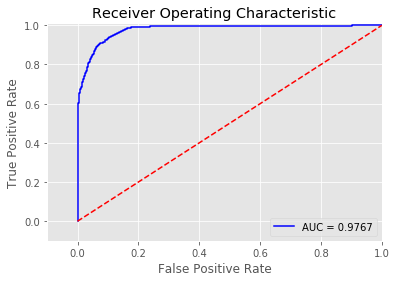

coef_: [[-8.68146434e-07  2.33335222e-05 -2.28607529e-05  1.13058761e-05
  -1.13784936e-05  9.93323358e-01]]


In [23]:
#Logistic_Regression_CV Model

from sklearn.linear_model import LogisticRegressionCV
alpha = np.logspace(-2, 2, 20) #for regularisation

lr_model_cv = LogisticRegressionCV(Cs=alpha, penalty='l1', solver='liblinear', cv=fold)
lr_model_cv.fit(X_train, y_train)

y_pred_score_cv = lr_model_cv.predict_proba(X_test)
# print('y_pred_score_cv:')
# print(y_pred_score_cv)

fpr_cv, tpr_cv, thresholds_cv = roc_curve(y_test, y_pred_score_cv[:, 1])
roc_auc_cv = auc(fpr_cv,tpr_cv)
print('auc:', roc_auc_cv)

#ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_cv, tpr_cv, 'b',label='AUC = %0.4f'% roc_auc_cv)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('coef_:', lr_model_cv.coef_)

auc_test: 0.998163531896248
best_params {'max_depth': 6, 'n_estimators': 200}


test classification report: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      2490
           1       0.98      1.00      0.99      2438

    accuracy                           0.99      4928
   macro avg       0.99      0.99      0.99      4928
weighted avg       0.99      0.99      0.99      4928



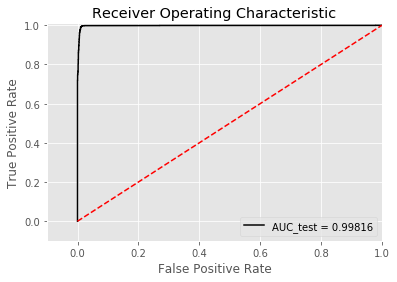

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=6, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'max_depth': range(2, 16, 2),
                         'n_estimators': [80, 100, 120, 160, 200]},
             pre_dispatch='2*n_jobs', refit=True,

In [25]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

param_test = {    
    'n_estimators':[80, 100, 120,160,200],
    'max_depth':range(2,16,2)
}

xgb_cv = GridSearchCV(estimator=xgb.XGBClassifier(learning_rate =0.1,
                                                   n_estimators=100, 
                                                   max_depth=6,
                                                   min_child_weight=1,  
                                                   gamma=0, 
                                                   subsample=0.8,
                                                   colsample_bytree=0.8,
                                                   objective= 'binary:logistic', 
                                                   nthread=4,
                                                   scale_pos_weight=1, 
                                                   seed=27),
                       param_grid = param_test,
                       scoring='roc_auc',
                       n_jobs=4,
                       iid=False, 
                       cv=5
                       )

xgb_cv.fit(X_train, y_train)

test_est_xgb_cv = xgb_cv.predict(X_test)
test_est_p_xgb_cv = xgb_cv.predict_proba(X_test)[:,1]

fpr_test_xgb_cv, tpr_test_xgb_cv, th_test_xgb_cv = metrics.roc_curve(y_test, test_est_p_xgb_cv)
test_roc_auc_xgb_cv = auc(fpr_test_xgb_cv,tpr_test_xgb_cv)

print('auc_test:', test_roc_auc_xgb_cv)
print('best_params',xgb_cv.best_params_)
print('\n')
print('test classification report: \n',metrics.classification_report(y_test, test_est_xgb_cv))

#ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_test_xgb_cv, tpr_test_xgb_cv, color="k",label='AUC_test = %0.5f'% test_roc_auc_xgb_cv)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print(xgb_cv)